# Обучение с учителем: качество модели
Ко мне обратился интернет-магазин «В один клик», который продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

# План моей работы:
1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

## Шаг 1. Загрузка данных

In [1]:
!pip install phik -q

In [2]:
!pip install shap -q

In [3]:
!pip install mlxtend -q

In [4]:
from sklearn import tree
from sklearn.tree import plot_tree
import warnings 
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import phik
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)

from sklearn.metrics import (
    f1_score, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report)

from mlxtend.plotting import plot_decision_regions

RANDOM_STATE = 42

In [5]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep=';')
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')
    
pd.set_option('display.float_format', '{:,.2f}'.format)

In [6]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"


In [8]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


Все файлы не соответствуют стандартам оформления данных. Поэтому сейчас будем их приводить в порядок.

In [10]:
market_file = market_file.rename(columns={'Покупательская активность':'покупательская_активность',
                                          'Тип сервиса':'тип_сервиса',
                                          'Разрешить сообщать':'разрешить_сообщать',
                                          'Маркет_актив_6_мес':'маркет_6_мес',
                                          'Маркет_актив_тек_мес':'маркет_тек_мес',
                                          'Длительность':'длительность',
                                          'Акционные_покупки':'акционные_покупки',
                                          'Популярная_категория':'популярная_категория',
                                          'Средний_просмотр_категорий_за_визит':'средний_просмотр_категорий_за_визит',
                                          'Неоплаченные_продукты_штук_квартал':'неоплаченные_продукты_штук_квартал',
                                          'Ошибка_сервиса':'ошибка_сервиса',
                                          'Страниц_за_визит':'страниц_за_визит'
})

In [11]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_6_мес                         1300 non-null   float64
 5   маркет_тек_мес                       1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [12]:
market_money = market_money.rename(columns={'Период':'период',
                                            'Выручка':'выручка'
})

In [13]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [14]:
market_time = market_time.rename(columns={'Период':'период'})

In [15]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [16]:
money = money.rename(columns={'Прибыль':'прибыль'})

In [17]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


Поменяем тип данных в money:
- прибыль - изменим на float

В остальных датафреймах данные соответствуют своему типу

##  Предобработка данных

In [18]:
def to_num (column):
    return pd.to_numeric(column.str.replace(',','.'))
money['прибыль'] = to_num(money['прибыль'])

In [19]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Тип данных успешно изменён!

Проверю наличие пропущенных значений и дубликатов в датафреймах.

In [20]:
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_6_мес                           0
маркет_тек_мес                         0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [21]:
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [22]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [23]:
money.isna().sum()

id         0
прибыль    0
dtype: int64

Пропущенных значений нет, проверим дубликаты в данных.

In [24]:
market_file.duplicated().sum()

0

In [25]:
market_money.duplicated().sum()

0

In [26]:
market_time.duplicated().sum()

0

In [27]:
money.duplicated().sum()

0

Явные дубликаты отсутствуют, сейчас проверю на неявные

Начну с категориальных данных

In [28]:
market_file['покупательская_активность'].value_counts()

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

In [29]:
market_file['тип_сервиса'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

In [30]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

In [31]:
market_file['тип_сервиса'].value_counts()

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

In [32]:
market_file['разрешить_сообщать'].value_counts()

да     962
нет    338
Name: разрешить_сообщать, dtype: int64

In [33]:
market_file['популярная_категория'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

In [34]:
market_money['период'].value_counts()

препредыдущий_месяц    1300
предыдущий_месяц       1300
текущий_месяц          1300
Name: период, dtype: int64

In [35]:
market_time['период'].value_counts()

предыдцщий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

In [36]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [37]:
market_time['период'].value_counts()

предыдущий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

В категориальных данных изменила, что было необходимо. 

Вывод: пропуски в данных не были обнаружены; тип данных в необходимом месте изменила на float; явные дубликаты отсутствуют; неявные дубликаты были устранены.

## Исследовательский анализ данных

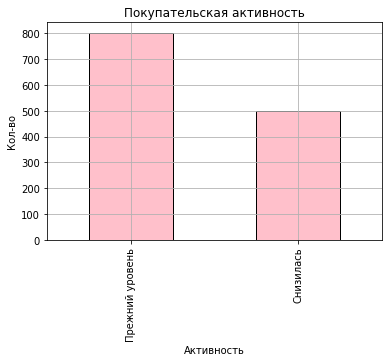

In [38]:
market_file['покупательская_активность'].value_counts().plot(title = 'Покупательская активность', kind = 'bar', color='pink', edgecolor='black', grid=True)
plt.xlabel('Активность')
plt.ylabel('Кол-во')
plt.show()

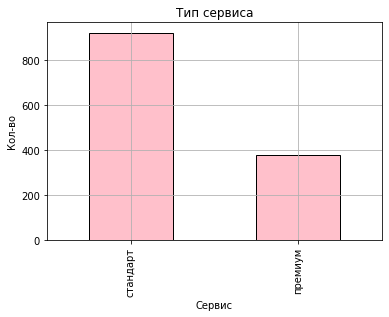

In [39]:
market_file['тип_сервиса'].value_counts().plot(title = 'Тип сервиса', kind = 'bar', color='pink', edgecolor='black', grid=True)
plt.xlabel('Сервис')
plt.ylabel('Кол-во')
plt.show()

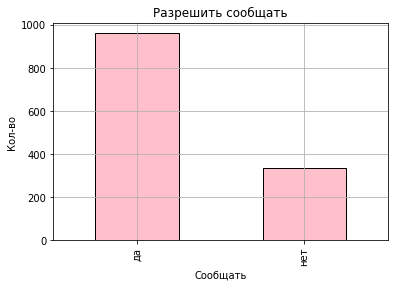

In [40]:
market_file['разрешить_сообщать'].value_counts().plot(title = 'Разрешить сообщать', kind = 'bar', color='pink', edgecolor='black', grid=True)
plt.xlabel('Сообщать')
plt.ylabel('Кол-во')
plt.show()

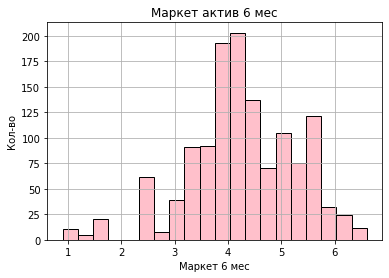

In [41]:
market_file['маркет_6_мес'].plot(title = 'Маркет актив 6 мес', kind = 'hist', color='pink', edgecolor='black', grid=True, bins=20)
plt.xlabel('Маркет 6 мес')
plt.ylabel('Кол-во')
plt.show()

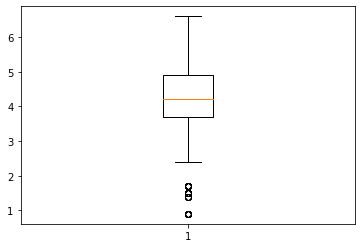

In [42]:
plt.boxplot(market_file['маркет_6_мес'])
plt.show()

In [43]:
market_file['маркет_6_мес'].describe()

count   1,300.00
mean        4.25
std         1.01
min         0.90
25%         3.70
50%         4.20
75%         4.90
max         6.60
Name: маркет_6_мес, dtype: float64

Распределение похоже на нормальное

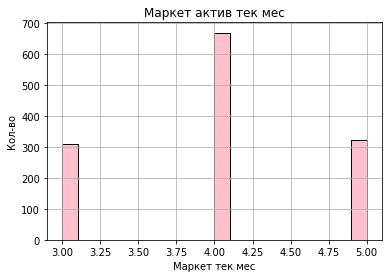

In [44]:
market_file['маркет_тек_мес'].plot(title = 'Маркет актив тек мес', kind = 'hist', color='pink', edgecolor='black', grid=True, bins=20)
plt.xlabel('Маркет тек мес')
plt.ylabel('Кол-во')
plt.show()

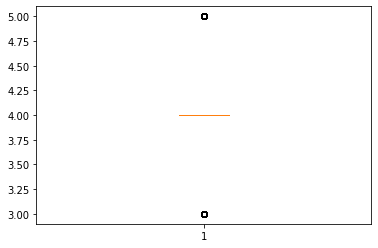

In [45]:
plt.boxplot(market_file['маркет_тек_мес'])
plt.show()

In [46]:
market_file['маркет_тек_мес'].describe()

count   1,300.00
mean        4.01
std         0.70
min         3.00
25%         4.00
50%         4.00
75%         4.00
max         5.00
Name: маркет_тек_мес, dtype: float64

Мультимодальное распределение. Есть 3 пика - 3.0, 4.5 и 5.0

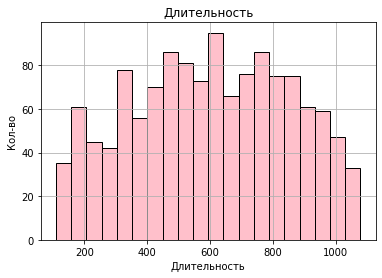

In [47]:
market_file['длительность'].plot(title = 'Длительность', kind = 'hist', color='pink', edgecolor='black', grid=True, bins=20)
plt.xlabel('Длительность')
plt.ylabel('Кол-во')
plt.show()

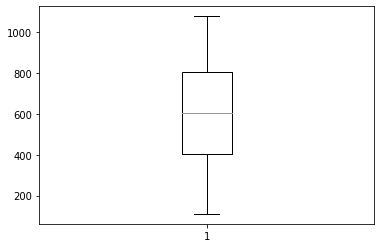

In [48]:
plt.boxplot(market_file['длительность'])
plt.show()

In [49]:
market_file['длительность'].describe()

count   1,300.00
mean      601.90
std       249.86
min       110.00
25%       405.50
50%       606.00
75%       806.00
max     1,079.00
Name: длительность, dtype: float64

Распределение стремится к нормальному. Самый новый пользователь зарегистрировался 110 дней назад, а самый давнейший 1079 дней назад. 

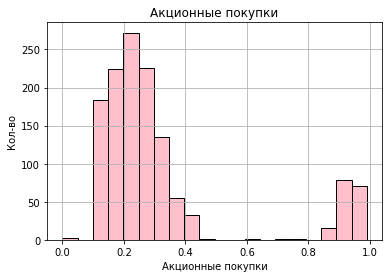

In [50]:
market_file['акционные_покупки'].plot(title = 'Акционные покупки', kind = 'hist', color='pink', edgecolor='black', grid=True, bins=20)
plt.xlabel('Акционные покупки')
plt.ylabel('Кол-во')
plt.show()

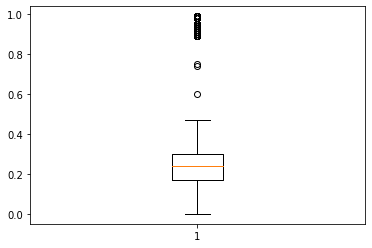

In [51]:
plt.boxplot(market_file['акционные_покупки'])
plt.show()

In [52]:
market_file['акционные_покупки'].describe()

count   1,300.00
mean        0.32
std         0.25
min         0.00
25%         0.17
50%         0.24
75%         0.30
max         0.99
Name: акционные_покупки, dtype: float64

Распределение бимодальное.

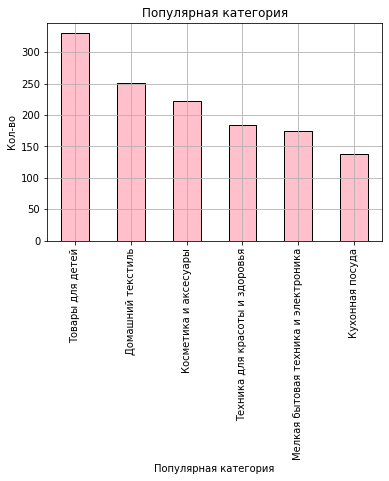

In [53]:
market_file['популярная_категория'].value_counts().plot(title = 'Популярная категория', kind = 'bar', color='pink', edgecolor='black', grid=True)
plt.xlabel('Популярная категория')
plt.ylabel('Кол-во')
plt.show()

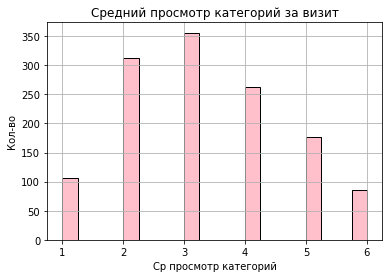

In [54]:
market_file['средний_просмотр_категорий_за_визит'].plot(title = 'Средний просмотр категорий за визит', kind = 'hist', color='pink', edgecolor='black', grid=True, bins=20)
plt.xlabel('Ср просмотр категорий')
plt.ylabel('Кол-во')
plt.show()

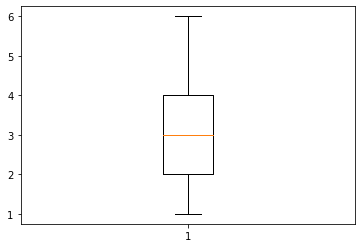

In [55]:
plt.boxplot(market_file['средний_просмотр_категорий_за_визит'])
plt.show()

In [56]:
market_file['средний_просмотр_категорий_за_визит'].describe()

count   1,300.00
mean        3.27
std         1.36
min         1.00
25%         2.00
50%         3.00
75%         4.00
max         6.00
Name: средний_просмотр_категорий_за_визит, dtype: float64

Похоже на нормальное распределение

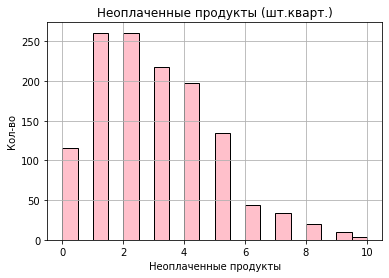

In [57]:
market_file['неоплаченные_продукты_штук_квартал'].plot(title = 'Неоплаченные продукты (шт.кварт.)', kind = 'hist', color='pink', edgecolor='black', grid=True, bins=20)
plt.xlabel('Неоплаченные продукты')
plt.ylabel('Кол-во')
plt.show()

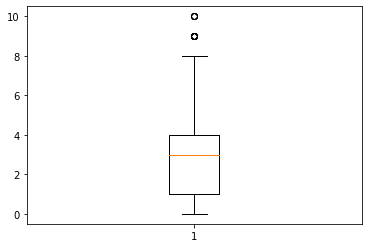

In [58]:
plt.boxplot(market_file['неоплаченные_продукты_штук_квартал'])
plt.show()

In [59]:
market_file['неоплаченные_продукты_штук_квартал'].describe()

count   1,300.00
mean        2.84
std         1.97
min         0.00
25%         1.00
50%         3.00
75%         4.00
max        10.00
Name: неоплаченные_продукты_штук_квартал, dtype: float64

Похоже на нормальное распределение, но немного скошенное

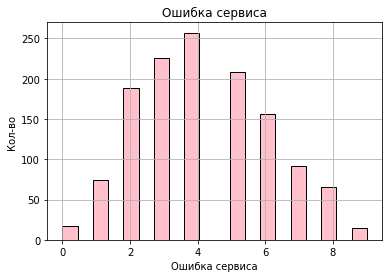

In [60]:
market_file['ошибка_сервиса'].plot(title = 'Ошибка сервиса', kind = 'hist', color='pink', edgecolor='black', grid=True, bins=20)
plt.xlabel('Ошибка сервиса')
plt.ylabel('Кол-во')
plt.show()

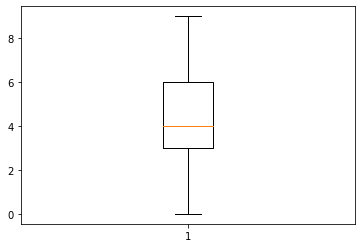

In [61]:
plt.boxplot(market_file['ошибка_сервиса'])
plt.show()

In [62]:
market_file['ошибка_сервиса'].describe()

count   1,300.00
mean        4.19
std         1.96
min         0.00
25%         3.00
50%         4.00
75%         6.00
max         9.00
Name: ошибка_сервиса, dtype: float64

Нормальное распределение

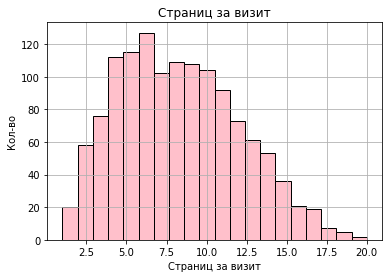

In [63]:
market_file['страниц_за_визит'].plot(title = 'Страниц за визит', kind = 'hist', color='pink', edgecolor='black', grid=True, bins=20)
plt.xlabel('Страниц за визит')
plt.ylabel('Кол-во')
plt.show()

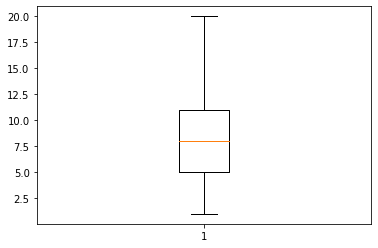

In [64]:
plt.boxplot(market_file['страниц_за_визит'])
plt.show()

In [65]:
market_file['страниц_за_визит'].describe()

count   1,300.00
mean        8.18
std         3.98
min         1.00
25%         5.00
50%         8.00
75%        11.00
max        20.00
Name: страниц_за_визит, dtype: float64

Распределение похоже на нормальное, немного скошенное

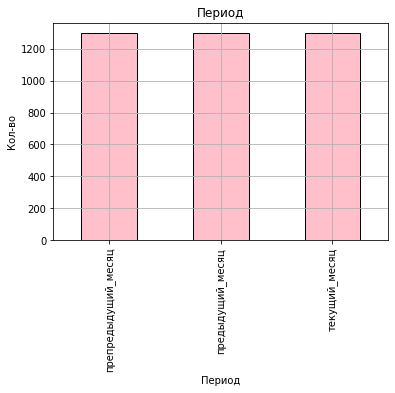

In [66]:
market_money['период'].value_counts().plot(title = 'Период', kind = 'bar', color='pink', edgecolor='black', grid=True)
plt.xlabel('Период')
plt.ylabel('Кол-во')
plt.show()

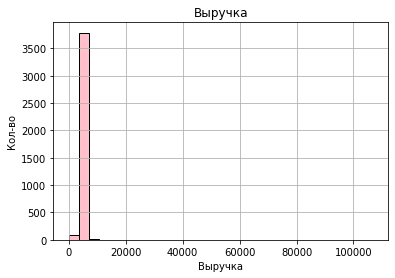

In [67]:
market_money['выручка'].plot(title = 'Выручка', kind = 'hist', color='pink', edgecolor='black', grid=True, bins=30)
plt.xlabel('Выручка')
plt.ylabel('Кол-во')
plt.show()

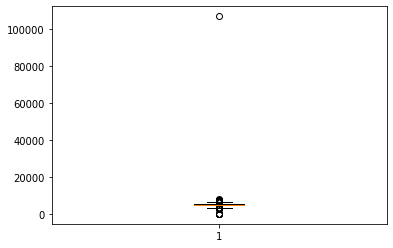

In [68]:
plt.boxplot(market_money['выручка'])
plt.show()

In [69]:
market_money['выручка'].describe()

count     3,900.00
mean      5,025.70
std       1,777.70
min           0.00
25%       4,590.15
50%       4,957.50
75%       5,363.00
max     106,862.20
Name: выручка, dtype: float64

Выручка равная 106862 похожа на выброс, удалим её

In [70]:
market_money['выручка'].sort_values(ascending=False).head(10)

98     106,862.20
435      7,799.40
262      7,605.30
1481     7,557.00
2388     7,547.80
566      7,467.90
2266     7,410.00
1003     7,401.60
1632     7,401.60
1573     7,374.00
Name: выручка, dtype: float64

In [71]:
id_to_delete = market_money[market_money['выручка'] == 106862.2]['id'].tolist()
market_money = market_money.query('id != @id_to_delete')

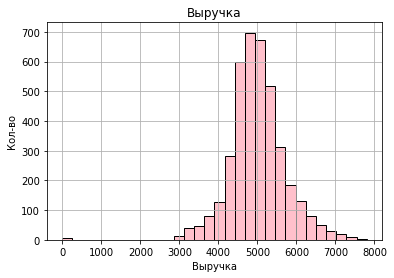

In [72]:
market_money['выручка'].plot(title = 'Выручка', kind = 'hist', color='pink', edgecolor='black', grid=True, bins=30)
plt.xlabel('Выручка')
plt.ylabel('Кол-во')
plt.show()

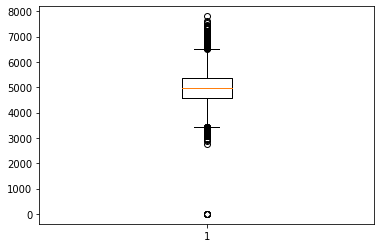

In [73]:
plt.boxplot(market_money['выручка'])
plt.show()

Распределение нормальное. Большинство наблюдений находятся в промежутке от 4500 5000

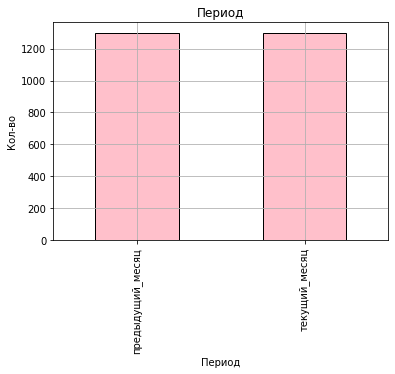

In [74]:
market_time['период'].value_counts().plot(title = 'Период', kind = 'bar', color='pink', edgecolor='black', grid=True)
plt.xlabel('Период')
plt.ylabel('Кол-во')
plt.show()

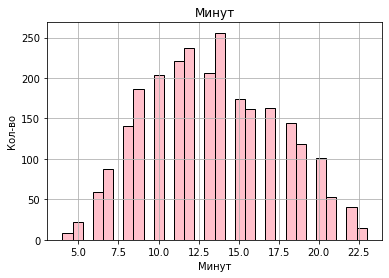

In [75]:
market_time['минут'].plot(title = 'Минут', kind = 'hist', color='pink', edgecolor='black', grid=True, bins=30)
plt.xlabel('Минут')
plt.ylabel('Кол-во')
plt.show()

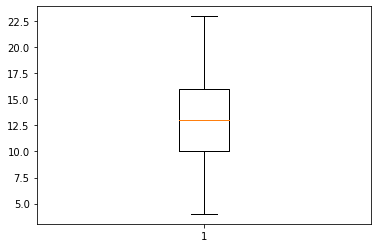

In [76]:
plt.boxplot(market_time['минут'])
plt.show()

In [77]:
market_time['минут'].describe()

count   2,600.00
mean       13.34
std         4.08
min         4.00
25%        10.00
50%        13.00
75%        16.00
max        23.00
Name: минут, dtype: float64

Здесь представлено нормальное распределение

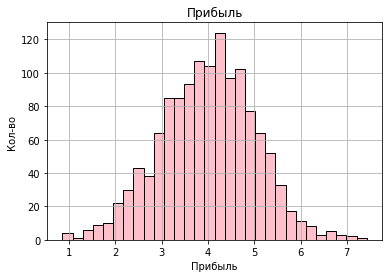

In [78]:
money['прибыль'].plot(title = 'Прибыль', kind = 'hist', color='pink', edgecolor='black', grid=True, bins=30)
plt.xlabel('Прибыль')
plt.ylabel('Кол-во')
plt.show()

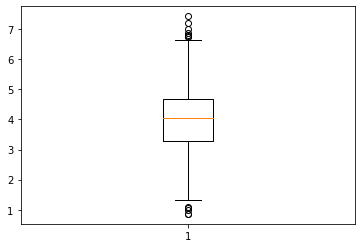

In [79]:
plt.boxplot(money['прибыль'])
plt.show()

In [80]:
money['прибыль'].describe()

count   1,300.00
mean        4.00
std         1.01
min         0.86
25%         3.30
50%         4.04
75%         4.67
max         7.43
Name: прибыль, dtype: float64

Здесь также представлено нормальное распределение

Отберу клиентов с покупательской активностью не менее 3 мес

In [81]:
no_active = market_money.loc[(market_money['выручка'] == 0)]['id'].unique()
print(f'id пользователей с непостоянной покупательской активностью: {no_active}')

id пользователей с непостоянной покупательской активностью: [215348 215357 215359]


In [82]:
active_users_three_months = market_money[market_money.id.isin(no_active) == False]
print('Всего строк market_money:', len(market_money))
print('Строк после отсеивания пользователей с непостоянной активностью:', len(active_users_three_months))

Всего строк market_money: 3897
Строк после отсеивания пользователей с непостоянной активностью: 3888


In [83]:
no_active_users_three_months = market_money[market_money.id.isin(no_active) == True]
print('\nПользователи с непостоянной активностью:')
no_active_users_three_months


Пользователи с непостоянной активностью:


,id,период,выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
27,215357,текущий_месяц,"5,986.30"
28,215357,препредыдущий_месяц,0.00
29,215357,предыдущий_месяц,0.00
33,215359,текущий_месяц,"4,735.00"
34,215359,предыдущий_месяц,0.00
35,215359,препредыдущий_месяц,0.00


In [84]:
print('Количество пользователей с постоянной покупательской активностью в течение последних трёх месяцев:', 
      active_users_three_months['id'].nunique())

Количество пользователей с постоянной покупательской активностью в течение последних трёх месяцев: 1296


Уберу пользователей, с непостоянной покупательской активностью за последние 3 мес

In [85]:
market_money = market_money[market_money.id.isin(no_active) == False]
market_money['id'].nunique()

1296

Вывод: я изучила, визуализировала, удалила выбросы в категориальных и количественных данных. Отобрала клиентов с покупательской активностью не менее 3 мес, их кол-во составило 1296 человек

## Объединение таблиц

Преобразую признак покупательская_активность. Прежний уровень будет = 0, снизилась = 1

In [86]:
def to_binary(value):
    try:
        if value == val_one:
            return 1
        elif value == val_two:
            return 0
    except:
            return 'Error'

In [87]:
val_one = 'Снизилась'
val_two = 'Прежний уровень'
market_file['покупательская_активность'] = market_file['покупательская_активность'].apply(to_binary)

print(market_file['покупательская_активность'].value_counts())

0    802
1    498
Name: покупательская_активность, dtype: int64


In [88]:
market_money_tek_mes = (market_money
                        .query('период == "текущий_месяц"')
                        .drop(['период'], axis=1)
                        .rename(columns={'выручка': 'выручка_текущий_месяц'}))

market_money_pre_mes = (market_money
                        .query('период == "предыдущий_месяц"')
                        .drop(['период'], axis=1)
                        .rename(columns={'выручка': 'выручка_предыдущий_месяц'}))

market_money_prepre_mes = (market_money
                            .query('период == "препредыдущий_месяц"')
                            .drop(['период'], axis=1)
                            .rename(columns={'выручка': 'выручка_препредыдущий_месяц'}))

market_time_tek_mes = (market_time
                        .query('период == "текущий_месяц"')
                        .drop(['период'], axis=1)
                        .rename(columns={'минут': 'минут_текущий_месяц'}))

market_time_pre_mes = (market_time
                        .query('период == "предыдущий_месяц"')
                        .drop(['период'], axis=1)
                        .rename(columns={'минут': 'минут_предыдущий_месяц'}))

Объединю датафреймы

In [89]:
merged_final = (market_file
                .merge(market_money_tek_mes, on='id')
                .merge(market_money_pre_mes, on='id')
                .merge(market_money_prepre_mes, on='id')
                .merge(market_time_tek_mes, on='id')
                .merge(market_time_pre_mes, on='id')
                .reset_index(drop=True))

In [90]:
merged_final.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_6_мес,маркет_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
0,215349,1,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,"4,971.60","5,216.00","4,472.00",10,12
1,215350,1,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,"5,058.40","5,457.50","4,826.00",13,8
2,215351,1,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,"6,610.40","6,158.00","4,793.00",13,11
3,215352,1,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,"5,872.50","5,807.50","4,594.00",11,8
4,215353,1,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,"5,388.50","4,738.50","5,124.00",10,10


Итоговая таблица готова

## Корреляционный анализ

interval columns not set, guessing: ['покупательская_активность', 'маркет_6_мес', 'маркет_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'минут_текущий_месяц', 'минут_предыдущий_месяц']


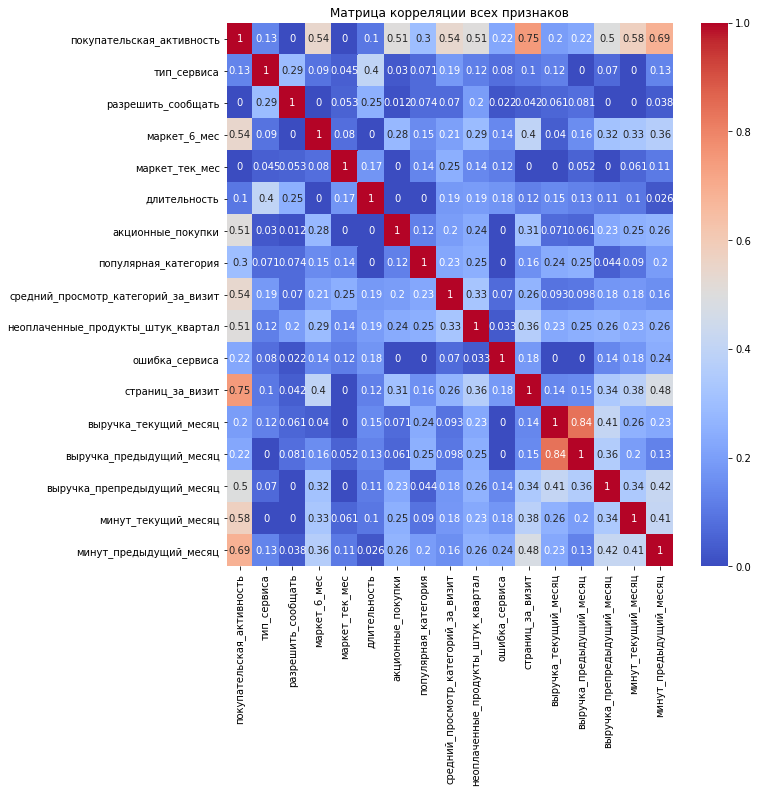

In [91]:
plt.figure(figsize=(10,10))
corr_phik_matrix = merged_final.drop('id',axis=1).phik_matrix()
sns.heatmap(corr_phik_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции всех признаков')
plt.show()

Вывод по матрице корреляции:
- целевой признак: покупательская_активность, остальные - входные.
- о мультиколлинеарности свидетельствует значение коэффициента корреляции от 0.9 до 0.95. Смотря на нашу матрицу корреляции, можно сделать вывод, что мультиколлинеарность отсутствует.

## Использование пайплайнов

Проверю дисбаланс классов

0   0.62
1   0.38
Name: покупательская_активность, dtype: float64


Text(0, 0.5, 'Частота встречаемости')

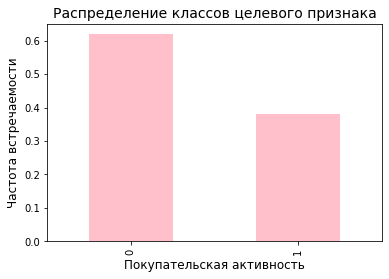

In [92]:
print(round(merged_final.покупательская_активность.value_counts(normalize=True), 2))

merged_final['покупательская_активность'].value_counts(normalize=True).plot(kind='bar', color='pink')
plt.title('Распределение классов целевого признака', size=14)
plt.xlabel('Покупательская активность', size=12)
plt.ylabel('Частота встречаемости', size=12)

Соотношение классов в целевом признаке непропорционально, поэтому будем использовать стратификацию

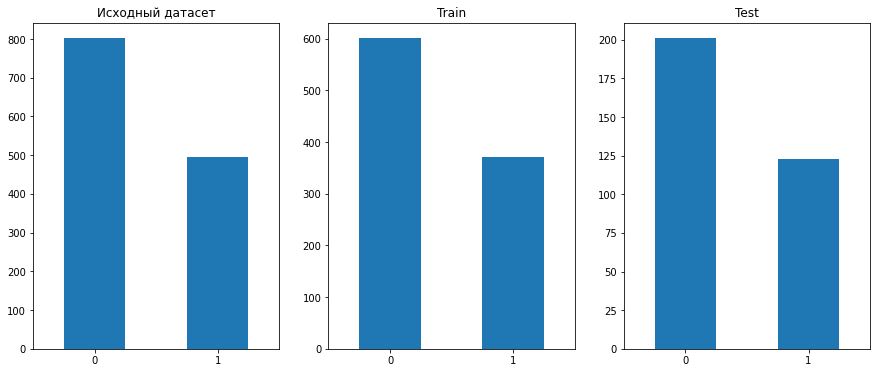

In [93]:
TEST_SIZE = 0.25

X = merged_final.drop(columns=['покупательская_активность', 'id'])
y = merged_final['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE, 
    test_size=TEST_SIZE, 
    stratify=y
) 

fig, ax = plt.subplots(1,3, figsize=(15, 6))
y.value_counts().plot(kind='bar', ax=ax[0], rot=0)
ax[0].set_title('Исходный датасет')
y_train.value_counts().plot(kind='bar', ax=ax[1], rot=0)
ax[1].set_title('Train')
y_test.value_counts().plot(kind='bar', ax=ax[2], rot=0)
ax[2].set_title('Test')
plt.show()

Разделение на выборки прошло корректно

In [94]:
warnings.filterwarnings('ignore')
ohe_columns = ['популярная_категория']

ord_columns = ['тип_сервиса', 'разрешить_сообщать']

num_columns = ['маркет_6_мес', 
               'маркет_тек_мес', 
               'длительность', 
               'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 
               'ошибка_сервиса', 
               'страниц_за_визит', 
               'выручка_текущий_месяц', 
               'выручка_предыдущий_месяц', 
               'выручка_препредыдущий_месяц', 
               'минут_текущий_месяц', 
               'минут_предыдущий_месяц']

ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))])

ord_pipe = Pipeline(
    [('ord', OrdinalEncoder(
    categories=[
        ['стандарт', 'премиум'], 
        ['да', 'нет']
    ], 
    handle_unknown='use_encoded_value', 
    unknown_value=np.nan))
                    ]
                   )

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
    
]


randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_iter=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                                                              ['да',
                    

In [95]:
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 0.8965925967289603


In [96]:
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.893156170367674


In [97]:
print ('Метрика лучшей модели на  Кросс валидационной выборке:', randomized_search.best_score_)

Метрика лучшей модели на  Кросс валидационной выборке: 0.8965925967289603


In [98]:
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.917647534684302


In [99]:
print(f'Параметры лучшей модели:\n{randomized_search.best_params_}')

Параметры лучшей модели:
{'preprocessor__num': MinMaxScaler(), 'models__C': 2, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}


In [100]:
pd.DataFrame(randomized_search.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,std_test_score,rank_test_score,param_models,mean_test_score,params
1,0.02,1,"LogisticRegression(penalty='l1', random_state=...",0.90,"{'preprocessor__num': MinMaxScaler(), 'models_..."
3,0.02,2,"LogisticRegression(penalty='l1', random_state=...",0.90,"{'preprocessor__num': MinMaxScaler(), 'models_..."
0,0.01,3,KNeighborsClassifier(),0.86,"{'preprocessor__num': StandardScaler(), 'model..."
2,0.02,4,DecisionTreeClassifier(random_state=42),0.84,"{'preprocessor__num': RobustScaler(), 'models_..."
4,0.02,4,DecisionTreeClassifier(random_state=42),0.84,"{'preprocessor__num': StandardScaler(), 'model..."


Вывод:
- Построила пайплайн и выбрала лучшую комбинацию гиперпараметров и модели с использованием 4х моделей.
- Лучшая модель: LogisticRegression(penalty='l1', random_state=42, solver='liblinear', c=2)
- Метрика лучшей модели на тренировочной выборке: 0.8965925967289603
- Метрика ROC-AUC на тестовой выборке: 0.893156170367674

## Анализ важности признаков

In [101]:
ohe_encoder = OneHotEncoder(sparse_output=False, drop='first')
X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe_encoder.transform(X_test[ohe_columns])
ohe_encoder_col_names = ohe_encoder.get_feature_names_out()

ord_encoder = OrdinalEncoder()
X_train_ord = ord_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ord_encoder.transform(X_test[ord_columns])
ord_encoder_col_names = ord_encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_encoder_col_names)

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_encoder_col_names)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_first = pd.concat([X_train_ohe, X_train_ord], axis=1)
X_train_final = pd.concat([X_train_first, X_train_scaled], axis=1)

X_test_first = pd.concat([X_test_ohe, X_test_ord], axis=1)
X_test_final = pd.concat([X_test_first, X_test_scaled], axis=1)

print('Размерности выборок:')

shape_data = {'Выборка': ['X_train_final', 'X_test_final', 'y_train', 'y_test'], 
              'Размер': [X_train_final.shape, X_test_final.shape, y_train.shape, y_test.shape]} 

display(pd.DataFrame(shape_data))

Размерности выборок:


,Выборка,Размер
0,X_train_final,"(972, 20)"
1,X_test_final,"(324, 20)"
2,y_train,"(972,)"
3,y_test,"(324,)"


In [102]:
clf_best = LogisticRegression(solver='liblinear', C=2, penalty='l1', random_state=RANDOM_STATE)
clf_best.fit(X_train_final, y_train)
y_pred = clf_best.predict(X_test_final)

clf_best_probas = clf_best.predict_proba(X_test_final)[:,1]

print('Метрики Best Model:')
roc_auc_cv = cross_val_score(clf_best, X_train_final, y_train, scoring='roc_auc').mean()
print(f'ROC-AUC на тренировочной выборке: {(roc_auc_cv)}')
print(f'ROC-AUC на тестовой выборке: {(roc_auc_score(y_test, y_pred))}')

clf_best_acc = accuracy_score(y_test, y_pred)
print('Accuracy:', clf_best_acc)

clf_best_f1 = f1_score(y_test, y_pred, pos_label=1)
print('F1-score:', clf_best_f1)

Метрики Best Model:
ROC-AUC на тренировочной выборке: 0.8960373836646565
ROC-AUC на тестовой выборке: 0.8881810459895645
Accuracy: 0.904320987654321
F1-score: 0.8669527896995708


In [103]:
best_model = randomized_search.best_estimator_.named_steps['models']
best_model

LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')

In [104]:
data_preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['популярная_категория']),
                                ('ord',
                                 Pipeline(steps=[('ord',
                                                  OrdinalEncoder(categories=[['стандарт',
                                                                              'премиум'],
                                                                             ['да',
                                                                              'нет']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 ['тип_сервиса', 'разрешить_сообщать']),
                                ('num', MinMaxScaler(),
                                 ['маркет_6_мес', 'маркет_тек_мес',
                                  'длительность', 'акционные_покупки',
                                  'средний_просмотр_категорий_за_визит',
                                  'неоплаченные_продукты_штук_квартал',
                                  'ошибка_сервиса', 'страниц_за_визит',
                                  'выручка_текущий_месяц',
                                  'выручка_предыдущий_месяц',
                                  'выручка_препредыдущий_месяц',
                                  'минут_текущий_месяц',
                                  'минут_предыдущий_месяц'])])

In [105]:
new_column_names = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
new_column_names

array(['ohe__популярная_категория_Косметика и аксесуары',
       'ohe__популярная_категория_Кухонная посуда',
       'ohe__популярная_категория_Мелкая бытовая техника и электроника',
       'ohe__популярная_категория_Техника для красоты и здоровья',
       'ohe__популярная_категория_Товары для детей', 'ord__тип_сервиса',
       'ord__разрешить_сообщать', 'num__маркет_6_мес',
       'num__маркет_тек_мес', 'num__длительность',
       'num__акционные_покупки',
       'num__средний_просмотр_категорий_за_визит',
       'num__неоплаченные_продукты_штук_квартал', 'num__ошибка_сервиса',
       'num__страниц_за_визит', 'num__выручка_текущий_месяц',
       'num__выручка_предыдущий_месяц',
       'num__выручка_препредыдущий_месяц', 'num__минут_текущий_месяц',
       'num__минут_предыдущий_месяц'], dtype=object)

In [106]:
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train_final, y_train)

dummy_model_preds = dummy_model.predict(X_test_final)

print('Метрики Dummy Model:')
d_roc_auc_cv = cross_val_score(dummy_model, X_train_final, y_train, scoring='roc_auc').mean()
print(f'ROC-AUC на тренировочной выборке: {(d_roc_auc_cv)}')

dummy_roc = roc_auc_score(y_test, dummy_model_preds)
print('ROC-AUC на тестовой выборке:', dummy_roc)

dummy_acc = accuracy_score(y_test, dummy_model_preds)
print('Accuracy:', dummy_acc)

dummy_f1 = f1_score(y_test, dummy_model_preds, pos_label=1)
print('F1-score:', dummy_f1)

Метрики Dummy Model:
ROC-AUC на тренировочной выборке: 0.5
ROC-AUC на тестовой выборке: 0.5
Accuracy: 0.6203703703703703
F1-score: 0.0


In [107]:
dummy_model = DummyClassifier(random_state=RANDOM_STATE, strategy='stratified')
dummy_model.fit(X_train_final, y_train)
dummy_model_preds = dummy_model.predict(X_test_final)

print('Метрики Dummy Model:')
d_roc_auc_cv = cross_val_score(dummy_model, X_train_final, y_train, scoring='roc_auc').mean()
print(f'ROC-AUC на тренировочной выборке: {(d_roc_auc_cv)}')

dummy_roc = roc_auc_score(y_test, dummy_model_preds)
print('ROC-AUC на тестовой выборке:', dummy_roc)

dummy_acc = accuracy_score(y_test, dummy_model_preds)
print('Accuracy:', dummy_acc)

dummy_f1 = f1_score(y_test, dummy_model_preds, pos_label=1)
print('F1-score:', dummy_f1)

Метрики Dummy Model:
ROC-AUC на тренировочной выборке: 0.4922086962996054
ROC-AUC на тестовой выборке: 0.4945394976337823
Accuracy: 0.5216049382716049
F1-score: 0.37751004016064255


Результаты модели LogisticRegression лучше, чем DummyModel. Значит, выбранная мной модель адекватна и эффективна.

Метрики у лучшей модели:
- ROC-AUC на тренировочной выборке: 0.8960373836646565
- ROC-AUC на тестовой выборке: 0.8881810459895645
- F1-score: 0.8669527896995708

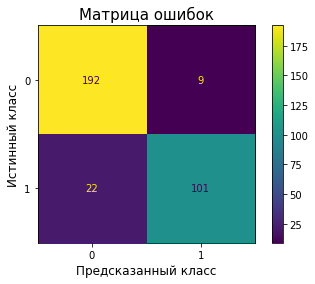

In [108]:
ConfusionMatrixDisplay.from_estimator(clf_best, X_test_final, y_test)
plt.title('Матрица ошибок', size=15)
plt.xlabel('Предсказанный класс', size=12)
plt.ylabel('Истинный класс', size=12)
plt.show()

Модель верно предсказала:
- прежний уровень - 192 раза
- снизилась - 101 раз
- ошибка FN - 22 раза
- ошибка FP - 9 раз

Попробую улучшить значение FN с помощью смены порога.

In [109]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.6]
columns = []
precision = []
recall = []
accuracy = []
roc_auc = []
f1_sc = []
false_positive = []
false_negative = []
true_positive = []
true_negative = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    preds = np.where(clf_best.predict_proba(X_test_final)[:,1] > i, 1, 0)
    precision.append(round(precision_score(y_test, preds), 2))
    recall.append(round(recall_score(y_test, preds), 2))
    accuracy.append(round(accuracy_score(y_test, preds), 2))
    roc_auc.append(round(roc_auc_score(y_test, preds), 3))
    f1_sc.append(round(f1_score(y_test, preds), 3))   
    false_positive.append(confusion_matrix(y_test, preds)[0, 1])
    false_negative.append(confusion_matrix(y_test, preds)[1, 0])
    true_positive.append(confusion_matrix(y_test, preds)[1, 1])
    true_negative.append(confusion_matrix(y_test, preds)[0, 0])
  
frame = pd.DataFrame(zip(columns, 
                         precision, 
                         recall,
                         accuracy, 
                         roc_auc, 
                         f1_sc,
                         false_positive, 
                         false_negative, 
                         true_positive, 
                         true_negative), 
                     columns = ['Порог', 
                                'precision', 
                                'recall', 
                                'accuracy', 
                                'roc_auc', 
                                'f1_score',
                                'false_positive', 
                                'false_negative', 
                                'true_positive ', 
                                'true_negative']) 

frame

,Порог,precision,recall,accuracy,roc_auc,f1_score,false_positive,false_negative,true_positive,true_negative
0,y_pred_0.1,0.52,0.93,0.64,0.70,0.66,107,9,114,94
1,y_pred_0.2,0.67,0.88,0.79,0.81,0.76,53,15,108,148
2,y_pred_0.3,0.75,0.86,0.84,0.84,0.80,36,17,106,165
3,y_pred_0.4,0.86,0.83,0.88,0.87,0.84,17,21,102,184
4,y_pred_0.6,0.97,0.80,0.92,0.90,0.88,3,24,99,198


Лучше оставить порог без изменений, значение того, что мы ошибочно выдадим 9 людям скидку, не очень плохо

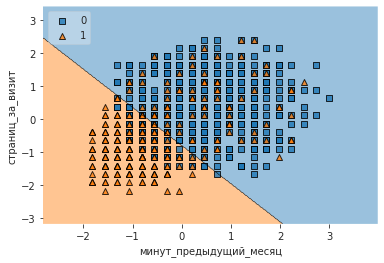

In [110]:
columns = ['страниц_за_визит', 'минут_предыдущий_месяц']

X_new_train = X_train_final[columns]
X_new_scalled = scaler.fit_transform(X_new_train)

clf_best_new = LogisticRegression(solver='liblinear', C=2, penalty='l1', random_state=RANDOM_STATE)
clf_best_new.fit(X_new_scalled, y_train)

sns.set_style(style='white')
plot_decision_regions(X_new_scalled, y_train.to_numpy(), clf=clf_best_new, legend=2)
plt.xlabel(columns[1])
plt.ylabel(columns[0])
plt.show()

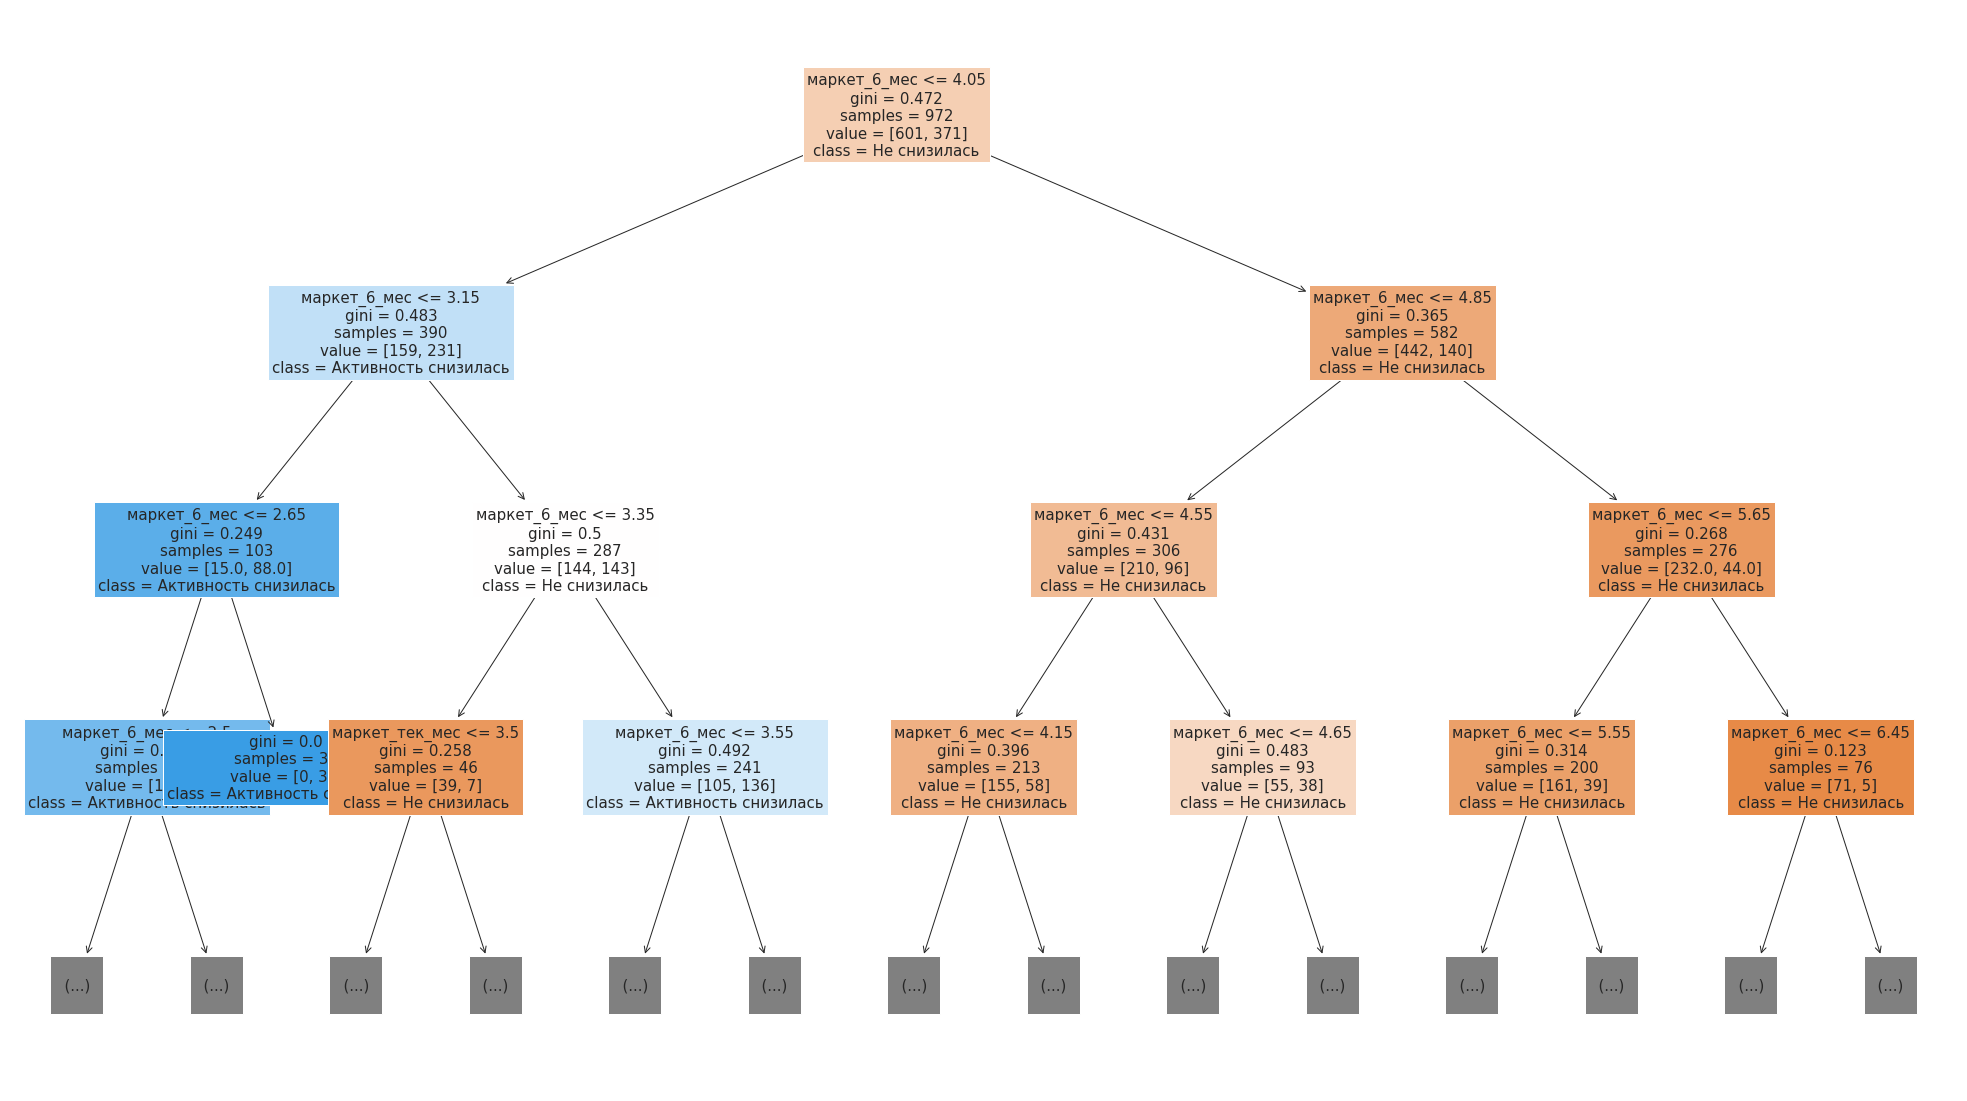

In [112]:
# код ревьюера


tree_model = DecisionTreeClassifier()

features = X_train[['маркет_6_мес', 'маркет_тек_мес']]
tree_model.fit(features, y_train)

fig = plt.figure(figsize=(35,20))
tree_plot = tree.plot_tree(tree_model, 
              feature_names=features.columns.values, 
              class_names=['Не снизилась','Активность снизилась'],
              filled=True,
              fontsize = 15,
              max_depth = 3     #Это чтобы прорисовывало 3 уровня, не глубже. То есть даже не нужно отдельно строить модель глубиной 3
                 )
plt.show()

Разделяющая граница оптимальная

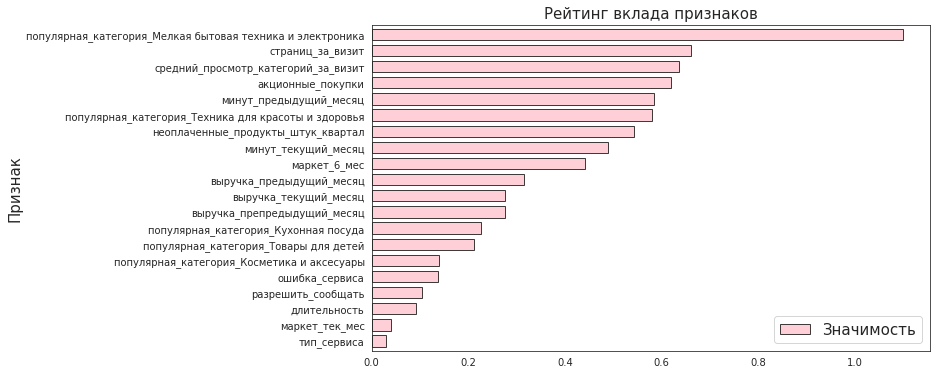

In [113]:
coeffs = clf_best.coef_[0]
feature_importance = pd.DataFrame({'Признак': X_train_final.columns, 'Значимость': np.abs(coeffs)})
feature_importance = feature_importance.sort_values(by='Значимость', ascending=True)
feature_importance.plot(x='Признак', 
                        y='Значимость', 
                        kind='barh', 
                        figsize=(10, 6), 
                        ec='black', 
                        alpha=0.75, 
                        lw=1, color='pink', 
                        width=0.7)
plt.legend(prop={'size': 15})
plt.ylabel('Признак', size=15)
plt.title('Рейтинг вклада признаков', size=15)
plt.show()

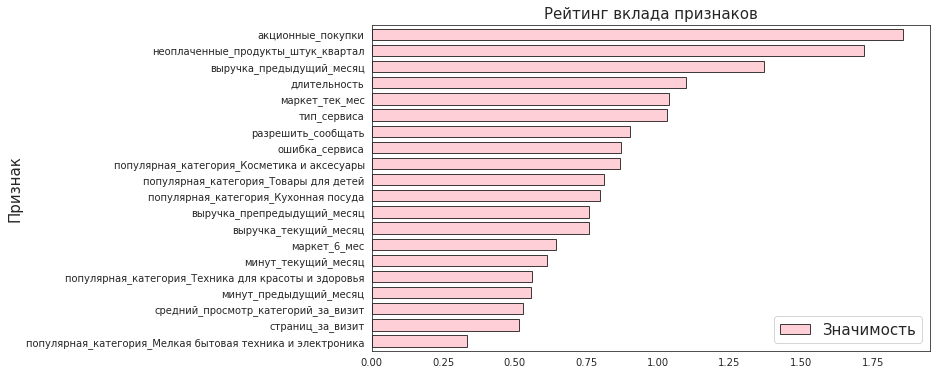

In [114]:
coef = clf_best.coef_[0]
exp_coef = np.exp(coef)
feature_importance = pd.DataFrame({'Признак': X_train_final.columns, 'Значимость': np.abs(exp_coef)})
feature_importance = feature_importance.sort_values(by='Значимость', ascending=True)
feature_importance.plot(x='Признак', 
                        y='Значимость', 
                        kind='barh', 
                        figsize=(10, 6), 
                        ec='black', 
                        alpha=0.75, 
                        lw=1, color='pink', 
                        width=0.7)
plt.legend(prop={'size': 15})
plt.ylabel('Признак', size=15)
plt.title('Рейтинг вклада признаков', size=15)
plt.show()

Топ-5 признаков с наименьшим вкладом в модель:
- тип_сервиса
- маркет_тек_мес
- длительность
- разрешить_сообщать
- ошибка_сервиса

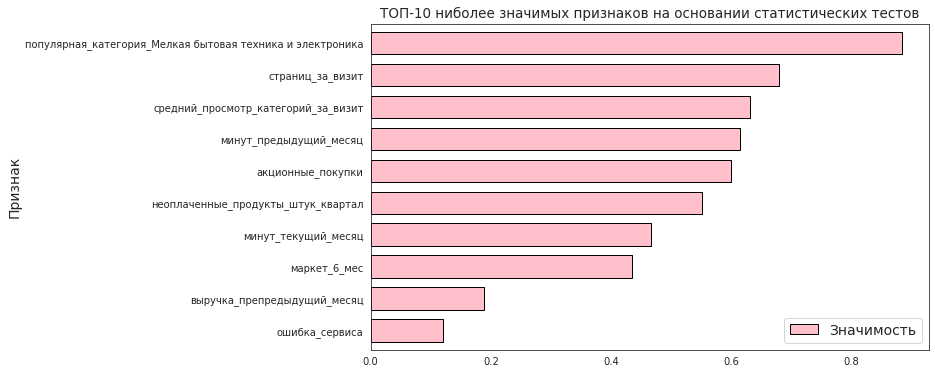

In [115]:
selector = SelectKBest(f_classif, k=10)

X_new = selector.fit_transform(X_train_final, y_train)

features_names = X_train_final.columns[selector.get_support(indices=True)]
X_train_new = X_train_final[list(features_names)]
X_test_new = X_test_final[list(features_names)]

clf_best_fit_new = LogisticRegression(solver='liblinear', C=2, penalty='l1', random_state=RANDOM_STATE)
clf_best_fit_new.fit(X_train_new, y_train)

coefficients = clf_best_fit_new.coef_[0]
feature_importance = pd.DataFrame({'Признак': features_names, 'Значимость': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Значимость', ascending=True)
feature_importance.plot(x='Признак', 
                        y='Значимость', 
                        kind='barh', 
                        figsize=(10, 6), 
                        color='pink', 
                        ec='black', 
                        lw=1, 
                        width=0.7)
plt.legend(prop={'size': 14})
plt.ylabel('Признак', size=14)
plt.title('ТОП-10 ниболее значимых признаков на основании статистических тестов', size=13.5)
plt.show()

Наиболее значимые признаки:
- популярная_категория_Мелкая бытовая техника и электроника
- страниц_за_визит
- средний_просмотр_категорий_за_визит
- минут_предыдущий_месяц
- акционные_покупки

Изучу важность признаков методом SHAP

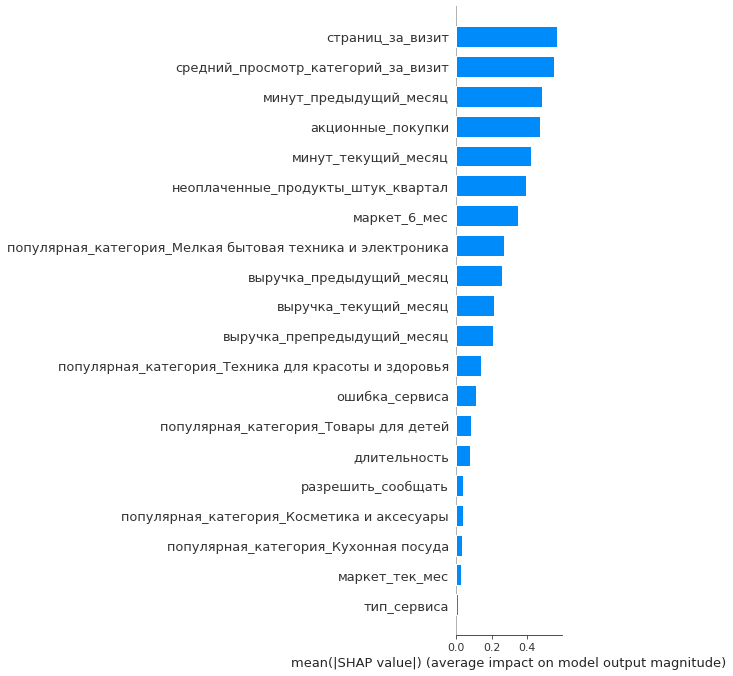

In [116]:
explainer = shap.Explainer(clf_best, X_test_final)
shap_values = explainer.shap_values(X_test_final)
shap.summary_plot(shap_values, X_test_final, plot_type='bar')
plt.show()

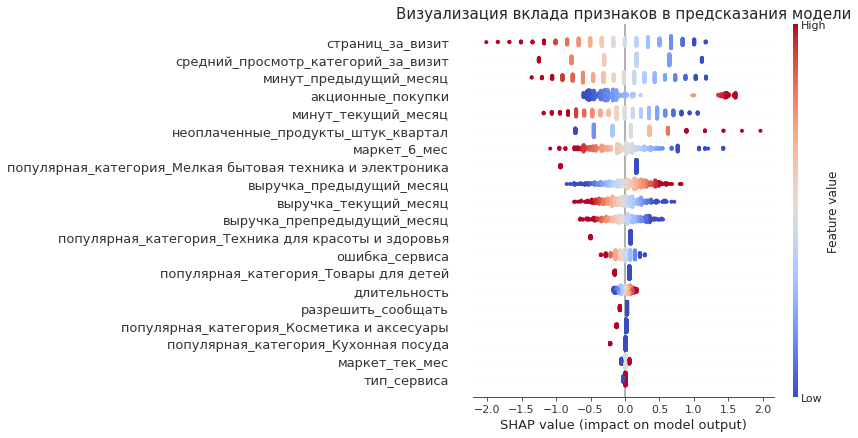

In [117]:
shap.summary_plot(shap_values, X_test_final, show=False, plot_size=[12, 6], cmap='coolwarm')
plt.title('Визуализация вклада признаков в предсказания модели', size=15, y=1)
plt.show()

Смотря на SHAP значение можно сделать следующие выводы:
- Наиболее значимые признаки: страниц_за_визит; средний_просмотр_категорий_за_визит; минут_предыдущий_месяц; акционные_покупки; минут_текущий_месяц
- Исходя из визуализации вклада признаков: высокие значения страниц_за_визит и минут_предыдущий_месяц уменьшают значение SHAP объектов и увеличивают вероятность принадлежности наблюдений к классу 0 
- Высокие значения акционные_покупки наоборот увеличивают значение SHAP объектов и увеличивают вероятность принадлежности наблюдений к классу 1

Общий вывод:
- Мало значимые признаки для модели: разрешить_сообщать; популярная_категория_Косметика и аксесуары; популярная_категория_Кухонная посуда; маркет_тек_мес; тип_сервиса
- Признаки, сильнее всего влияющие на целевой признак: страниц_за_визит; средний_просмотр_категорий_за_визит; минут_предыдущий_месяц; акционные_покупки; минут_текущий_месяц
- При моделировании и принятии бизнес-решений данных наблюдений стоит учесть: на покупательскую активность влияет наличие акция (можно их увеличить); чем дольше покупатель находится на сайте и чем больше просмотрит страниц, тем выше вероятность покупки


## Сегментация покупателей

In [118]:
def to_bin(value):
    try:
        if value == 1:
            return val_one
        elif value == 0:
            return val_two
    except:
            return 'Error'

In [119]:
clf_best_probas_train = clf_best.predict_proba(X_train_final)[:,1]

X_pred = clf_best.predict(X_train_final)

total_train = pd.concat([X_train, y_train], axis=1)
total_test = pd.concat([X_test, y_test], axis=1)

total_train['probas'] = clf_best_probas_train.tolist()
total_train['класс_прогноз'] = X_pred.tolist()
total_test['probas'] = clf_best_probas.tolist()
total_test['класс_прогноз'] = y_pred.tolist()

final = pd.concat([total_train, total_test])
final = pd.merge(final, merged_final['id'], left_index=True, right_index=True)

final['покупательская_активность'] = final['покупательская_активность'].apply(to_bin)

val_one = 'Снизится'
val_two = 'Не изменится'
final['класс_прогноз'] = final['класс_прогноз'].apply(to_bin)

final = final.rename(columns={'класс_прогноз': 'прогноз_покуп_актив'})

final = final.merge(money, on='id')

In [120]:
final.head()

,тип_сервиса,разрешить_сообщать,маркет_6_мес,маркет_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,...,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,покупательская_активность,probas,прогноз_покуп_актив,id,прибыль
0,стандарт,да,5.50,4,510,0.15,Мелкая бытовая техника и электроника,2,4,7,...,"6,014.20","5,170.50","4,347.00",6,20,Прежний уровень,0.05,Не изменится,215858,4.37
1,стандарт,да,5.10,4,199,0.23,Техника для красоты и здоровья,4,5,2,...,"3,789.70","6,400.00","4,597.00",13,11,Снизилась,0.80,Снизится,215361,4.03
2,стандарт,да,4.30,5,997,0.17,Мелкая бытовая техника и электроника,5,1,3,...,"3,798.40","4,113.00","4,626.00",10,13,Прежний уровень,0.07,Не изменится,215884,4.37
3,стандарт,да,5.60,4,342,0.94,Кухонная посуда,2,7,5,...,"4,766.20","4,930.00","5,269.00",19,14,Прежний уровень,0.75,Снизится,216564,5.58
4,премиум,да,3.60,5,873,0.39,Товары для детей,3,2,2,...,"4,600.00","3,716.00","4,691.00",10,10,Снизилась,0.80,Снизится,215715,4.87


Выделю следующие сегменты:
- покупатели с высокой прибыльностью (более 5)
- покупатели с высокой вероятностью снижения покупательской активности (более 0.7)

In [121]:
def segment(data):
    try:
        if data > 0.7:
            return 'Высокая вероятность снижения'
        if data < 0.7:
            return 'Низкая вероятность снижения'
    except:
        return 'Error'
    
final['прогноз_покуп_активности'] = final['probas'].apply(segment)

selected_segment = final[(final['прибыль'] > 5) & (final['probas'] > 0.7)]

selected_segment_good = final[(final['прибыль'] > 5) & (final['probas'] < 0.7)]

In [122]:
print('Количество покупателей выбранного сегмента:', selected_segment['id'].count())

Количество покупателей выбранного сегмента: 55


In [123]:
selected_segment = selected_segment.rename(columns={'разрешить_сообщать': 'рассылка'})
selected_segment.sort_values(by='прибыль', ascending=False)[['id', 
                                                             'прибыль',
                                                             'probas',
                                                             'прогноз_покуп_активности', 
                                                             'страниц_за_визит', 
                                                             'акционные_покупки', 
                                                             'популярная_категория', 
                                                             'тип_сервиса',
                                                             'рассылка']]

,id,прибыль,probas,прогноз_покуп_активности,страниц_за_визит,акционные_покупки,популярная_категория,тип_сервиса,рассылка
316,215401,7.43,0.92,Высокая вероятность снижения,4,0.30,Косметика и аксесуары,премиум,да
1105,215563,6.88,0.82,Высокая вероятность снижения,7,0.35,Косметика и аксесуары,премиум,да
902,215400,6.73,0.99,Высокая вероятность снижения,2,0.94,Товары для детей,стандарт,нет
503,215561,6.59,0.99,Высокая вероятность снижения,3,0.28,Косметика и аксесуары,стандарт,нет
1202,215505,6.55,0.93,Высокая вероятность снижения,3,0.31,Товары для детей,стандарт,да
104,215439,6.33,0.71,Высокая вероятность снижения,7,0.28,Товары для детей,премиум,нет
848,215368,6.27,0.89,Высокая вероятность снижения,1,0.24,Техника для красоты и здоровья,премиум,да
120,215494,6.12,0.92,Высокая вероятность снижения,3,0.23,Косметика и аксесуары,стандарт,нет
490,215613,5.99,0.95,Высокая вероятность снижения,4,0.93,Техника для красоты и здоровья,стандарт,да
149,215456,5.83,0.93,Высокая вероятность снижения,5,0.23,Косметика и аксесуары,стандарт,да


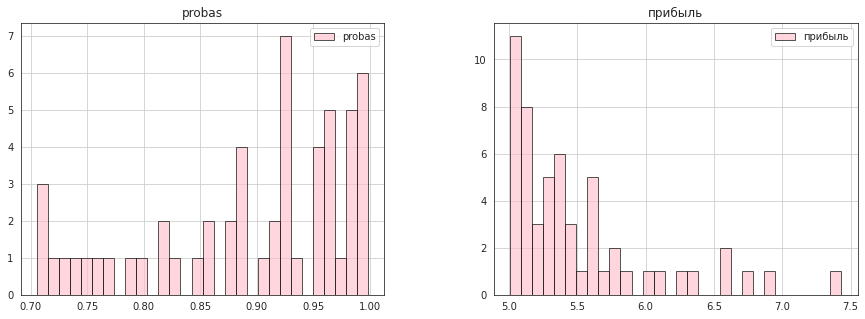

In [124]:
selected_segment[['probas', 'прибыль']].hist(bins=30, ec='black', lw=1, alpha=0.65, legend=True, figsize=(15, 5), color='pink');

- У многих покупателей, выбранного мной сегмента, вероятность принадлежности к классу снижение выше 0.9, а это значит, что высокая вероятность снижения покупательской активности, что может привести к уходу к конкурентам
- У большинства покупателей прибыльность до 6, но есть всплески и с прибыльностью выше 6.5. Зная, что макс показатель прибыльности составляет 7.43 для всех покупателей

In [125]:
print('Разрешение на рекламные рассылки в выбранном сегменте:')
print(selected_segment['рассылка'].value_counts())

Разрешение на рекламные рассылки в выбранном сегменте:
да     38
нет    17
Name: рассылка, dtype: int64


Большая часть покупателей хорошо относится к рекламной рассылке. За счет этого, мы можем заинтересовать больше потенциальных покупателей

In [126]:
print('Популярные категории в выбранном сегменте:')
print(selected_segment['популярная_категория'].value_counts())

Популярные категории в выбранном сегменте:
Товары для детей                        16
Косметика и аксесуары                   15
Домашний текстиль                        8
Кухонная посуда                          8
Техника для красоты и здоровья           6
Мелкая бытовая техника и электроника     2
Name: популярная_категория, dtype: int64


In [127]:
print('Типы сервиса в выбранном сегменте:')
print(selected_segment['тип_сервиса'].value_counts())

Типы сервиса в выбранном сегменте:
стандарт    31
премиум     24
Name: тип_сервиса, dtype: int64


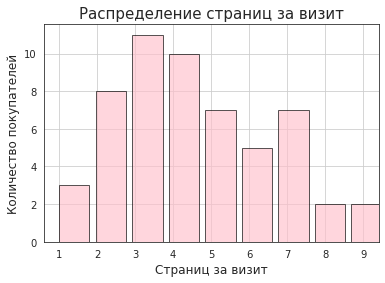

In [128]:
selected_segment['страниц_за_визит'].hist(bins=25, color='pink', ec='black', lw=1, alpha=0.65, width=0.8)
plt.title('Распределение страниц за визит', size=15)
plt.xlabel('Страниц за визит', size=12)
plt.ylabel('Количество покупателей', size=12)
plt.show()

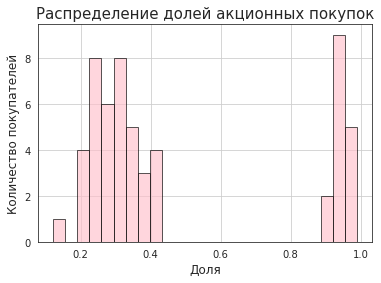

In [129]:
selected_segment['акционные_покупки'].hist(bins=25, color='pink', ec='black', lw=1, alpha=0.65)
plt.title('Распределение долей акционных покупок', size=15)
plt.xlabel('Доля', size=12)
plt.ylabel('Количество покупателей', size=12)
plt.show()

Вывод:
- Большая часть покупателей хорошо относится к рекламной рассылке. За счет этого, мы можем заинтересовать больше потенциальных покупателей
- В нашем сегементе 15 покупателей предпочтиают категорию Косметика и аксессуары и 16 - Товары для детей. Суммарно это состляет около 56% от всего сегмента. Стоит предложить этим покупателям скидки на данные категории. Или чаще предлагать эти категории данным пользователям во время их визита на сайт, что может увеличить покупательскую активность для выбранного мной сегмента

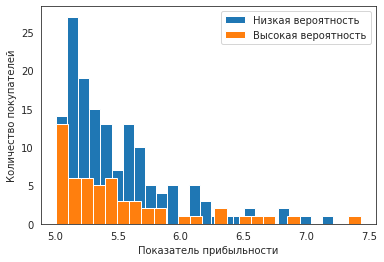

In [130]:
ax = selected_segment_good['прибыль'].plot(
    kind='hist',
    histtype='bar',
    bins=25,
    alpha=1)

selected_segment['прибыль'].plot(
    kind='hist',
    histtype='bar',
    bins=25,
    ax=ax)
plt.xlabel('Показатель прибыльности')
plt.ylabel('Количество покупателей')
plt.legend(['Низкая вероятность', 'Высокая вероятность'])
plt.show()

## Общий вывод

Поставленная задача:
- Подготовить имеющиеся данные для обучения
- Разработать модель, которая предскажет вероятность снижения покупательской активности
- Выделить сегмент покупателей и разработать персонализированные предложения, чтобы увеличить их покупательскую активность

Я выполнила следующее:
- изучила исходные данные
- провела предобработку данных (пропуски в данных отсутствуют; типы данных немного подкорректировала; явные дубликаты отсутствуют; неявные дубликаты подкорректировала)
- провела исследовательский анализ данных
- объединила таблицы
- провела корреляционный анализ
- использовала пайплайны
- провела анализ важности признаков
- провела сегментацию покупателей

- Самый новый пользователь зарегистрировался 110 дней назад, а самый давнейший 1079 дней назад.
- Отобрала клиентов с покупательской активностью не менее 3 мес, их кол-во составило 1296 человек
- Вывод по матрице корреляции: целевой признак: покупательская_активность, остальные - входные. О мультиколлинеарности свидетельствует значение коэффициента корреляции от 0.9 до 0.95. Смотря на нашу матрицу корреляции, можно сделать вывод, что мультиколлинеарность отсутствует.
- Соотношение классов в целевом признаке непропорционально, поэтому я использовала стратификацию
- Построила пайплайн и выбрала лучшую комбинацию гиперпараметров и модели с использованием 4х моделей. Лучшая модель: LogisticRegression(penalty='l1', random_state=42, solver='liblinear', c=2). Метрика лучшей модели на тренировочной выборке: 0.8965925967289603. Метрика ROC-AUC на тестовой выборке: 0.893156170367674
- Результаты модели LogisticRegression лучше, чем DummyModel. Значит, выбранная мной модель адекватна и эффективна.
- Модель верно предсказала: прежний уровень - 192 раза. снизилась - 101 раз. ошибка FN - 22 раза. ошибка FP - 9 раз
- Смотря на SHAP значение можно сделать следующие выводы:
- Наиболее значимые признаки: страниц_за_визит; средний_просмотр_категорий_за_визит; минут_предыдущий_месяц; акционные_покупки; минут_текущий_месяц
- Исходя из визуализации вклада признаков: высокие значения страниц_за_визит и минут_предыдущий_месяц уменьшают значение SHAP объектов и увеличивают вероятность принадлежности наблюдений к классу 0
- Высокие значения акционные_покупки наоборот увеличивают значение SHAP объектов и увеличивают вероятность принадлежности наблюдений к классу 1
- Общий вывод по SHAP значениям:
- Мало значимые признаки для модели: разрешить_сообщать; популярная_категория_Косметика и аксесуары; популярная_категория_Кухонная посуда; маркет_тек_мес; тип_сервиса
- Признаки, сильнее всего влияющие на целевой признак: страниц_за_визит; средний_просмотр_категорий_за_визит; минут_предыдущий_месяц; акционные_покупки; минут_текущий_месяц
- При моделировании и принятии бизнес-решений данных наблюдений стоит учесть: на покупательскую активность влияет наличие акция (можно их увеличить); чем дольше покупатель находится на сайте и чем больше просмотрит страниц, тем выше вероятность покупки
- Выделила следующие сегменты: покупатели с высокой прибыльностью (более 5) и покупатели с высокой вероятностью снижения покупательской активности (более 0.7)
- Количество покупателей выбранного сегмента: 55
- У многих покупателей, выбранного мной сегмента, вероятность принадлежности к классу снижение выше 0.9, а это значит, что высокая вероятность снижения покупательской активности, что может привести к уходу к конкурентам
- У большинства покупателей прибыльность до 6, но есть всплески и с прибыльностью выше 6.5. Зная, что макс показатель прибыльности составляет 7.43 для всех покупателей
- Большая часть покупателей хорошо относится к рекламной рассылке. За счет этого, мы можем заинтересовать больше потенциальных покупателей
- В нашем сегементе 15 покупателей предпочтиают категорию Косметика и аксессуары и 16 - Товары для детей. Суммарно это состляет около 56% от всего сегмента. Стоит предложить этим покупателям скидки на данные категории. Или чаще предлагать эти категории данным пользователям во время их визита на сайт, что может увеличить покупательскую активность для выбранного мной сегмента